In [1]:
from collections import deque
from env.tsp_env import TspEnv
from utils import tsp_plots
import numpy as np
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
NUMBER_OF_CITIES = 25

In [3]:
# Discount rate of future rewards
GAMMA = 1.0
# Learing rate for neural network
LEARNING_RATE = 0.001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 100000
# Frequency of neural net 
BATCH_SIZE = 5
# Number of game steps to play before starting training
REPLAY_START_SIZE = 10000
# Exploration rate (episolon) is probability of choosign a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.995
# Number of steps between target network update
SYNC_TARGET_STEPS = 5000

In [4]:
MAXIMUM_RUNS = 50000
MAXIMUM_TIME_MINS = 1440
NO_IMPROVEMENT_RUNS = 50000
NO_IMPROVEMENT_TIME = 1440
PLOT_NEW_BEST_ROUTES = True

In [5]:
class DQN(nn.Module):

    """
    Deep Q Network solver. Includes control variables, memory of 
    state/action/reward/end, neural net,and methods to act, 
    remember, and update neural net by sampling from memory.
    """
    
    def __init__(self, observation_space, n_actions):
        """Constructor method. Set up memory and neural nets."""
        
        self.n_actions = n_actions
        
        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX
        
        # Set up memory for state/action/reward/next_state/done
        # Deque will drop old data when full
        self.memory = deque(maxlen=MEMORY_SIZE)

        # Set up neural net
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
            )
        
        # Set loss function and optimizer
        self.objective = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.net.parameters(), lr=LEARNING_RATE)

        
    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""

        # Set up a dataframe array of q, city index, random
        action_df = pd.DataFrame()
        action_df['city'] = np.arange(NUMBER_OF_CITIES)
        q_values = self.net(torch.FloatTensor(state))
        action_df['q'] = q_values = q_values.detach().numpy()[0]
        action_df['visted'] = state[0][0:len(q_values)]
        action_df['random'] = np.random.random(NUMBER_OF_CITIES)
        
        # Filter to unvisted cities
        mask = action_df['visted'] == 0
        action_df = action_df[mask]
        
        # If no unvisted cities, action is to retuen to city 0
        if mask.sum() == 0:
            action = 0
        else:
            # Sort action table by Q or random order (for exploration)
            sort_col = ('random' if np.random.rand() < self.exploration_rate
                        else 'q')
            action_df.sort_values(sort_col, ascending=False, inplace=True)
            action = int(action_df['city'].iloc[0])

        return  action

            
    def forward(self, x):
        """Feed forward function for neural net"""
        
        return self.net(x)

In [6]:
class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=MEMORY_SIZE)

    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [7]:
def optimize(policy_net, target_net, memory):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < BATCH_SIZE:
        return    
 
    # Reduce exploration rate
    policy_net.exploration_rate *= EXPLORATION_DECAY
    policy_net.exploration_rate = max(EXPLORATION_MIN, 
                                      policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = random.sample(memory, BATCH_SIZE)
    for state, action, reward, state_next, terminal in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
       
        if not terminal:
            # For non-terminal actions get Q from policy net
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get next state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get targen net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent target net gradients being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (GAMMA * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward

        # Update neural net
        
        # Reset net gradients
        policy_net.optimizer.zero_grad()  
        # calculate loss
        loss_v = nn.MSELoss()(state_action_values, expected_state_action_values)
        # Backpropogate loss
        loss_v.backward()
        # Update network gradients
        policy_net.optimizer.step()  

    return

In [8]:
def main():
    """Main program loop"""
    
    # Set up environment
    time_start = time.time()
    env = TspEnv(number_of_cities = NUMBER_OF_CITIES, 
                 grid_dimensions = (100,100))
    
    # Get number of observations returned for state
    observation_space = env.observation_space.shape[0] * 2
    
    # Get number of actions possible
    n_actions = len(env.action_space)
    
    # Set up policy and target neural nets
    policy_net = DQN(observation_space, n_actions)
    target_net = DQN(observation_space, n_actions)
    
    # Copy weights from policy_net to target
    target_net.load_state_dict(policy_net.state_dict())
    
    # Set target net to eval rather than training mode
    # We do not train target net - ot is copied from policy net at intervals
    target_net.eval()    
    
    # Set up memomry
    memory = Memory()
    
    # Set up list for results
    results_run = []
    results_exploration = []
    total_rewards = []
    best_reward = -999999
    best_route = None
    
    # Set run and time of last best route
    run_last_best = 0
    time_last_best = time.time()

    # Set up run counter and learning loop
    step = 0
    run = 0
    continue_learning = True
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        # Increment run (episode) counter
        run += 1
        total_reward = 0
        
        # Start run and get first state observations
        state, reward, terminal, info = env.reset()
        total_reward += reward
        
        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])
        
        # Reset route
        route = []
        
        # Continue loop until episode complete
        while True:
            
            # Increment step counter
            step += 1
            
            # Get action to take
            action = policy_net.act(state)
            route.append(action)
            
            # Act
            state_next, reward, terminal, info = env.step(action)
            total_reward += reward
                     
            # Get observations for new state (s')
            state_next = np.reshape(state_next, [1, observation_space])
                        
            # Record state, action, reward, new state & terminal
            memory.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            # Update neural net            
            
            if len(memory.memory) >= REPLAY_START_SIZE:
                # Update policy net 
                optimize(policy_net, target_net, memory.memory)
                
                # Update the target network at intervals
                if step % SYNC_TARGET_STEPS == 0:
                    target_net.load_state_dict(policy_net.state_dict())
        
                 
            # Actions to take if end of game episode
            if terminal:
                # Clear print row content
                clear_row = '\r' + ' '*100 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run: 5.0f}, ', end='')
                exp = policy_net.exploration_rate
                print (f'exploration: {exp: 4.3f}, ', end='')
                print (f'total reward: {total_reward: 6.0f}', end='')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(policy_net.exploration_rate)
                total_rewards.append(total_reward)

                # Check for best route so far
                if total_reward > best_reward:
                    best_reward = total_reward
                    best_route = route
                    run_last_best = run
                    time_last_best = time.time()
                    time_elapsed = (time.time() - time_start) / 60
                    print(f'\nNew best run. Run : {run: 5.0f},  ' \
                          f'Time {time_elapsed: 4.0f}  ' \
                          f'Reward {total_reward: 6.0f}')
                                        # Plot new best route
                    if PLOT_NEW_BEST_ROUTES and step > REPLAY_START_SIZE:
                        if best_reward > 0:
                            tsp_plots.plot_route(env, best_route)
                            print()
                                
                # Check stopping conditions
                stop = False
                if step > REPLAY_START_SIZE:
                    if run == MAXIMUM_RUNS:
                        stop = True
                    elif time.time() - time_start > MAXIMUM_TIME_MINS * 60:
                        stop = True
                    elif time.time() - time_last_best > NO_IMPROVEMENT_TIME*60:
                        stop = True
                    elif run - run_last_best == NO_IMPROVEMENT_RUNS:
                        stop = True
                        
                if stop:
                    # End training
                    continue_learning = False
     
                # End episode
                break
            
    ############################# Plot results #################################
        
    # Plot result progress
    tsp_plots.plot_result_progress(total_rewards)
    
    # Plot best route
    tsp_plots.plot_route(env, best_route)
    
    ###################### Show route and distances ############################
    
    print ('Route')
    print (best_route)
    print ()
    print ('Best route distance')
    print (f'{env.state.calculate_distance(best_route):.0f}')

Run:     1, exploration:  1.000, total reward:   2117                                               
New best run. Run :     1,  Time    0  Reward   2117
Run:   401, exploration:  0.878, total reward:   2129                                               
New best run. Run :   401,  Time    1  Reward   2129


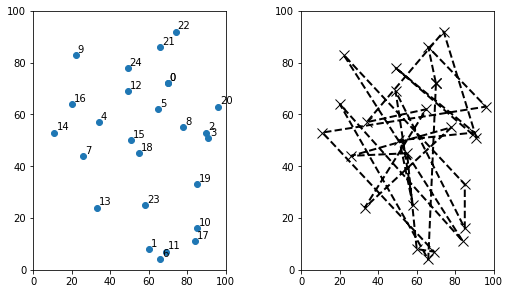


Run:   402, exploration:  0.774, total reward:   2145                                               
New best run. Run :   402,  Time    1  Reward   2145


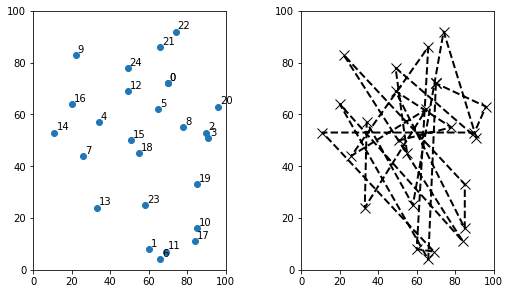


Run:   404, exploration:  0.603, total reward:   2218                                               
New best run. Run :   404,  Time    1  Reward   2218


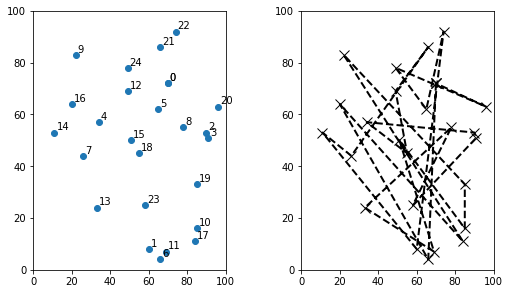


Run:   405, exploration:  0.532, total reward:   2277                                               
New best run. Run :   405,  Time    1  Reward   2277


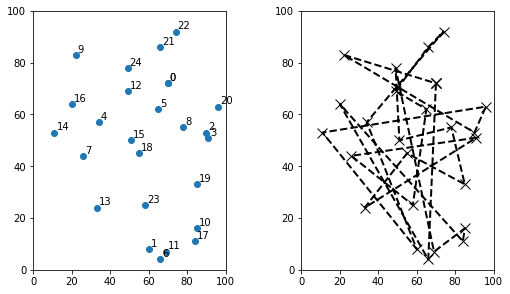


Run:   406, exploration:  0.469, total reward:   2342                                               
New best run. Run :   406,  Time    1  Reward   2342


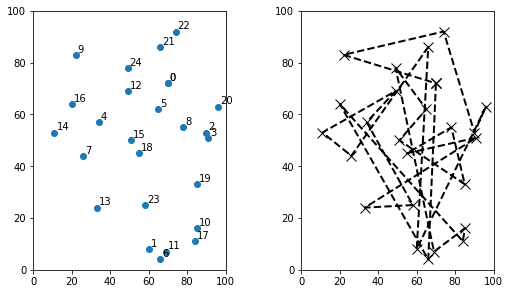


Run:   429, exploration:  0.026, total reward:   2403                                               
New best run. Run :   429,  Time    1  Reward   2403


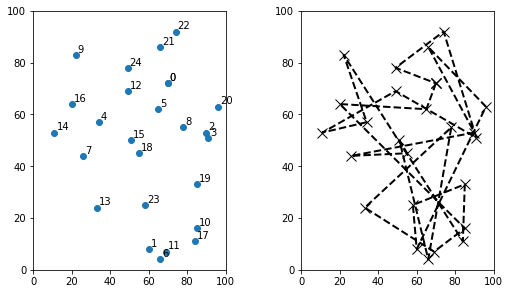


Run:   440, exploration:  0.010, total reward:   2474                                               
New best run. Run :   440,  Time    1  Reward   2474


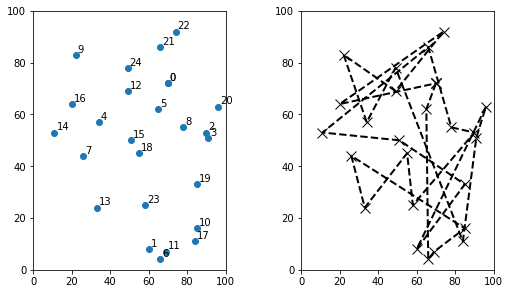


Run:   513, exploration:  0.010, total reward:   2527                                               
New best run. Run :   513,  Time    3  Reward   2527


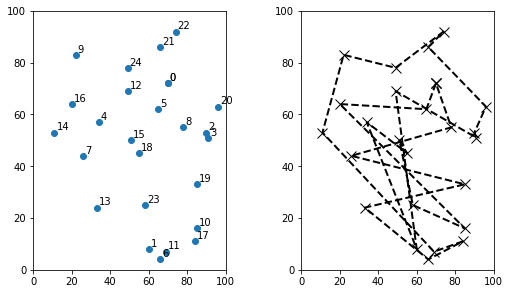


Run:   613, exploration:  0.010, total reward:   2585                                               
New best run. Run :   613,  Time    5  Reward   2585


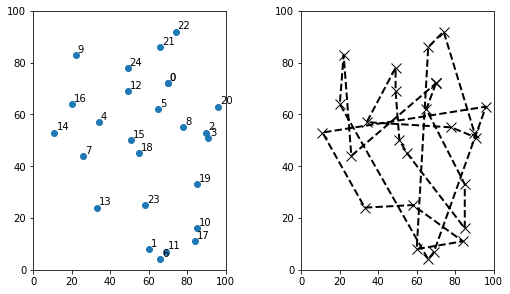


Run:   682, exploration:  0.010, total reward:   2637                                               
New best run. Run :   682,  Time    6  Reward   2637


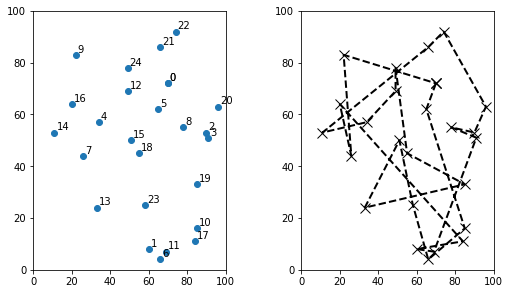


Run:   721, exploration:  0.010, total reward:   2647                                               
New best run. Run :   721,  Time    7  Reward   2647


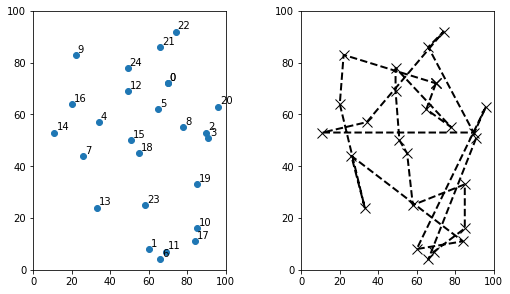


Run:   746, exploration:  0.010, total reward:   2658                                               
New best run. Run :   746,  Time    7  Reward   2658


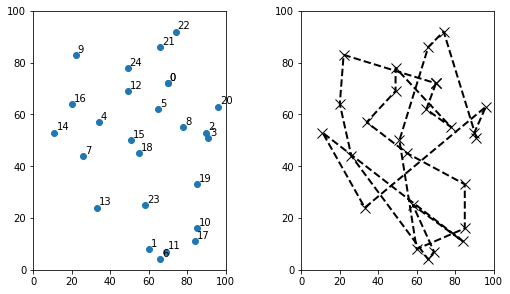


Run:   748, exploration:  0.010, total reward:   2728                                               
New best run. Run :   748,  Time    8  Reward   2728


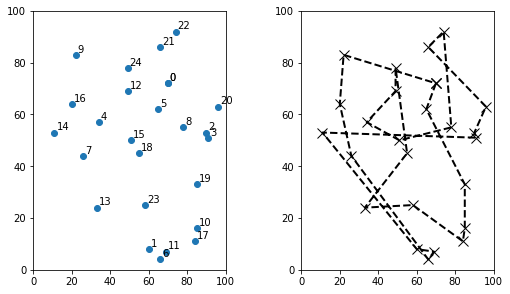


Run:   784, exploration:  0.010, total reward:   2744                                               
New best run. Run :   784,  Time    8  Reward   2744


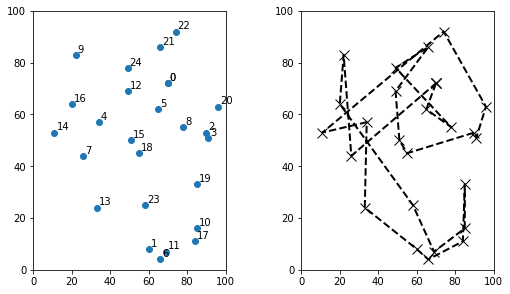


Run:   785, exploration:  0.010, total reward:   2754                                               
New best run. Run :   785,  Time    8  Reward   2754


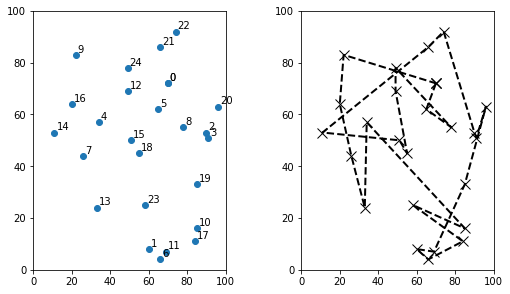


Run:   798, exploration:  0.010, total reward:   2766                                               
New best run. Run :   798,  Time    9  Reward   2766


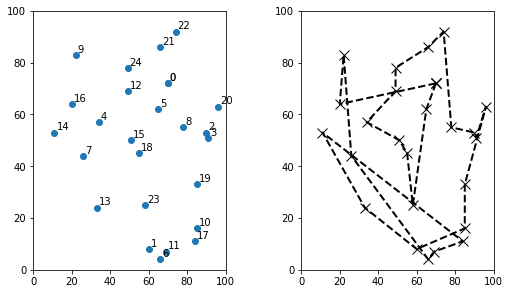


Run:   833, exploration:  0.010, total reward:   2786                                               
New best run. Run :   833,  Time    9  Reward   2786


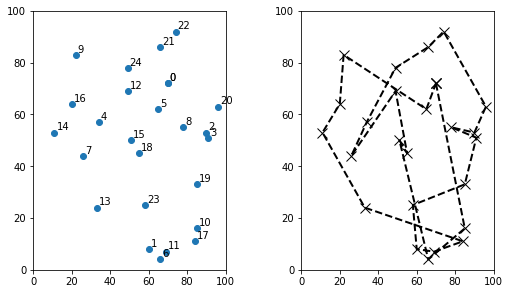


Run:   859, exploration:  0.010, total reward:   2799                                               
New best run. Run :   859,  Time   10  Reward   2799


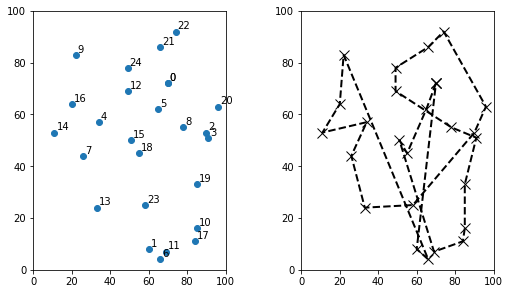


Run:   959, exploration:  0.010, total reward:   2821                                               
New best run. Run :   959,  Time   12  Reward   2821


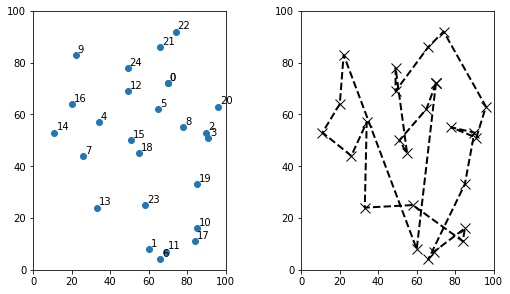


Run:   963, exploration:  0.010, total reward:   2828                                               
New best run. Run :   963,  Time   12  Reward   2828


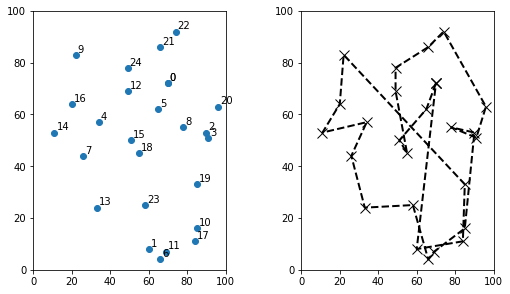


Run:   985, exploration:  0.010, total reward:   2840                                               
New best run. Run :   985,  Time   12  Reward   2840


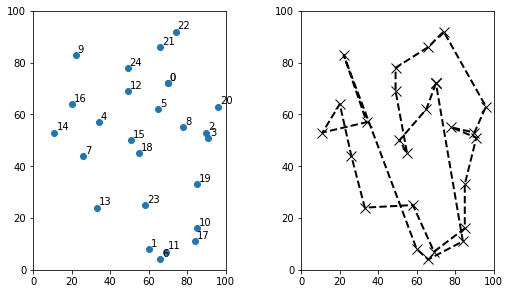


Run:  1049, exploration:  0.010, total reward:   2843                                               
New best run. Run :  1049,  Time   13  Reward   2843


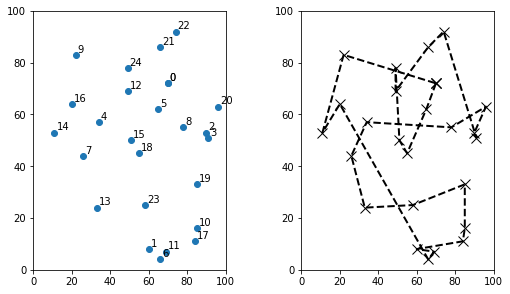


Run:  1181, exploration:  0.010, total reward:   2886                                               
New best run. Run :  1181,  Time   17  Reward   2886


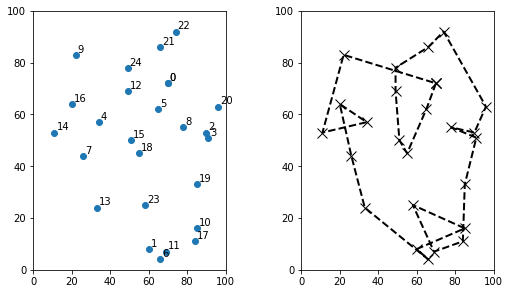


Run:  50000, exploration:  0.010, total reward:   2289                                              

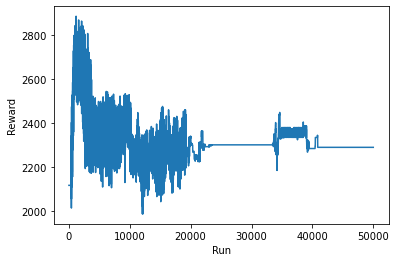

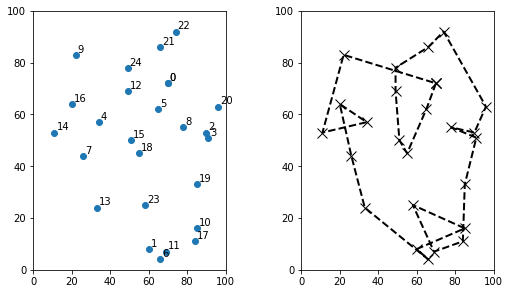

Route
[5, 18, 15, 12, 24, 21, 22, 20, 2, 8, 3, 19, 17, 11, 23, 10, 1, 6, 13, 7, 16, 4, 14, 9, 0]

Best route distance
497


In [9]:
main()